In [1]:
# Importamos las librerìas necesarias
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
# Importamos las capas de la red
from keras.layers import Dense, Flatten, Dropout
# Importamos un preprocesador de imagenes
from keras.preprocessing.image import ImageDataGenerator
# Importamos el modelo base
from keras.models import Model
# Importamos un métdo de regularización
from keras.regularizers import l2
#Importamos el callback de EarlyStopping
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Definimos un modelo de CNN
def clasificador():
    # Cargamos el modelo VGG16
    modelo = VGG16(include_top=False, input_shape=(224,224,3), weights="imagenet")
    # Definimos las capas de la red como no entrenables
    for capa in modelo.layers:
        capa.trainable = False
    
    # Definimos las capas de la red como entrenables
    modelo.get_layer("block3_conv1").trainable = True
    modelo.get_layer("block3_conv2").trainable = True
    modelo.get_layer("block3_conv3").trainable = True
    modelo.get_layer("block3_pool").trainable = True

    # Añadimos las capas adicionales
    flat1 = Flatten()(modelo.layers[-1].output) # Aplanamos el modelo, excepto la última capa
    x = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(flat1)
    # Añadimos una capa dropout para evitar el sobreajuste
    x = Dropout(rate=0.2)(x)
    output = Dense(units=1, activation="sigmoid", kernel_initializer="he_uniform")(x)
    modelo = Model(inputs=modelo.inputs, outputs=output)
    # Compilamos el modelo
    modelo.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    # Motramos el resumen del modelo
    modelo.summary()
    return modelo

In [3]:
# Generamos los gráficos de diagnóstico
def diagnostic_graphs(history):
    # Función de perdida
    plt.figure()
    plt.title("Función de pérdida")
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) +1)
    plt.plot(epochs, loss, "k--", label="Training loss")
    plt.plot(epochs, val_loss, "g--", label="Validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.savefig("loss_improved.pdf")
    plt.show()

    # Accuracy
    plt.figure()
    plt.title("Accuracy")
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "k--", label="Training accuracy")
    plt.plot(epochs, val_acc, "g--", label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig("accuracy_improved.pdf")
    plt.show()

In [4]:
def run_test_harness():
    # Definimos el modelo
    modelo = clasificador()
    # Definimos el early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    # Creamos un generador de datos
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90
    )
    test_datagen = ImageDataGenerator(featurewise_center=True)
    imagenet_mean = [123.68, 116.779, 103.939]
    train_datagen.mean = imagenet_mean
    test_datagen.mean = imagenet_mean

    # Definimos los iteradores de datos
    train_it = train_datagen.flow_from_directory(
        directory="Dataset_CNN/train/",
        class_mode="binary",
        batch_size=16,
        target_size=(224, 224)
    )

    test_it = test_datagen.flow_from_directory(
        directory="Dataset_CNN/test/",
        class_mode="binary",
        batch_size=16,
        target_size=(224,224)
    )

    # Entrenamos el modelo
    history = modelo.fit(train_it,
                        validation_data=test_it,
                        validation_steps=len(test_it),
                        epochs=50,
                        verbose=2,
                        callbacks=[early_stopping],
                        shuffle=True
                        )
    
    # Evaluamos el modelo
    _, accuracy = modelo.evaluate(x=test_it, steps=len(test_it), verbose=2)
    print(">> %.5f" % (accuracy * 100.0))

    # Generamos los gráficos de diagnóstico
    diagnostic_graphs(history)

    # Imprimimos el valor de la precisión
    print(f"El valor de la precisión del modelo en entrenamiento es: {history.history['accuracy'][-1]*100:.4f} %")

    # Generamos el reporte de clasificación
    y_pred = modelo.predict(test_it, steps=len(test_it), verbose=1)
    y_pred = (y_pred > 0.5).astype(int)
    y_true = test_it.classes
    print(classification_report(y_true, y_pred, target_names=test_it.class_indices.keys()))
    # Generamos la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de confusión:")
    print(cm)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

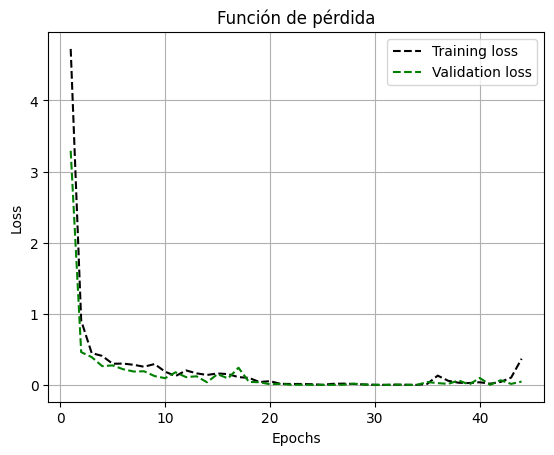

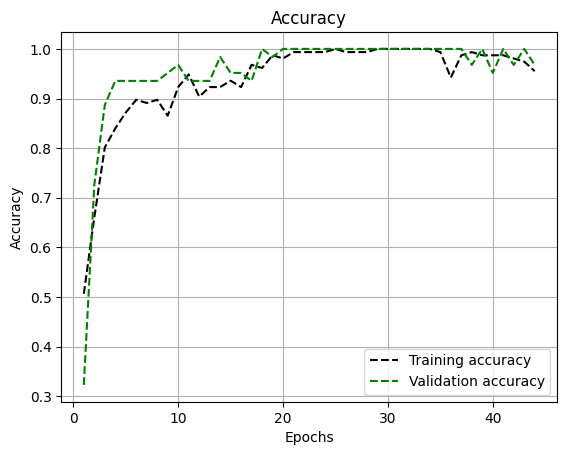

El valor de la precisión del modelo en entrenamiento es: 95.5128 %
4/4 [==============================] - 2s 557ms/step
                precision    recall  f1-score   support

   Carbonation       0.72      0.72      0.72        43
No_Carbonation       0.37      0.37      0.37        19

      accuracy                           0.61        62
     macro avg       0.54      0.54      0.54        62
  weighted avg       0.61      0.61      0.61        62

Matriz de confusión:
[[31 12]
 [12  7]]


In [5]:
# 👉 Entrenamos el modelo
run_test_harness()